In [41]:
# install libraries
pip install yfinance matplotlib pandas

SyntaxError: invalid syntax (4175262924.py, line 2)

In [21]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# download data for ASX200 index prices
ticker = '^AXJO'
start_date = '2015-01-01'
data = yf.download(ticker,start=start_date)
data = data[['Close']]
results = [] # store results

# set a range of MA to test -> short is 5-30 days, long is 30-100 days, 1 day increments
short_range = range(5,30,1)
long_range = range(30,100,1)

# if short window is >= long window, we skip and continue to next loop
for short in short_range:
    for long in long_range:
        if short >= long:
            continue 

# calculate moving averages and set buy/sell signals 
df = data.copy() # df creates a copy of data so the previous loop doesn't affect current one
df['short_MA'] = data['Close'].rolling(window=short).mean()
df['long_MA'] = data['Close'].rolling(window=long).mean()
df['Signal'] = (df['short_MA']>df['long_MA']).astype(int)
df.loc[df.index[:long-1],'Signal'] = 0 # go to long-1 rows and set signal column to 0
df['Position'] = df['Signal'].shift(1) # today's position is based on yesterday's signal

# calculate returns
df['Return'] = df['Close'].pct_change() 
df['Strategy_Return'] = df['Return'] * df['Position']
df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod()

# Get final cumulative return and store result
final_return = df['Cumulative_Strategy_Return'].iloc[-1] # value in last row of backtest results -> final cumulative
results.append((short, long, final_return)) # this way, for every iteration, one row of data is collected -> short,long,return

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Short_MA', 'Long_MA', 'FinalReturn'])

# Sort to find the best pair
best = results_df.sort_values(by='FinalReturn', ascending=False).iloc[0]
print(f"Best combination → Short MA: {best['Short_MA']}, Long MA: {best['Long_MA']}, Final Return: {round(best['FinalReturn'], 2)}")

# Optionally view top 10
print(results_df.sort_values(by='FinalReturn', ascending=False).head(10))


[*********************100%***********************]  1 of 1 completed

Best combination → Short MA: 29.0, Long MA: 99.0, Final Return: 1.08
   Short_MA  Long_MA  FinalReturn
0        29       99     1.077611


[*********************100%***********************]  1 of 1 completed


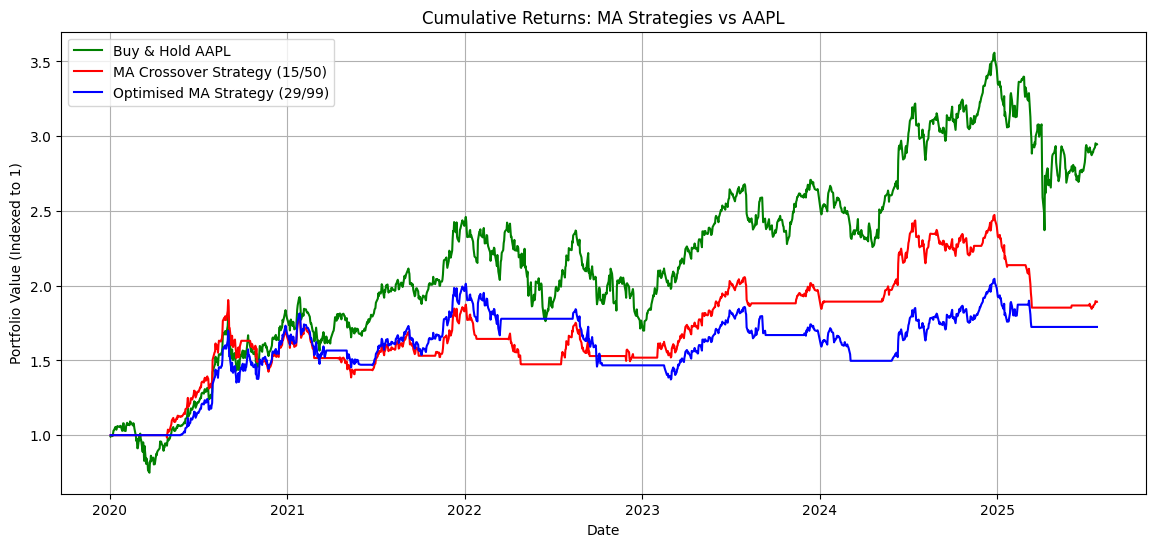

In [40]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# parameters
ticker = "AAPL"          
start_date = "2020-01-01"
optimised_short_term_MA = 29 
optimised_long_term_MA = 99 
short_term_MA = 15 
long_term_MA = 50 

# load data
data = yf.download(ticker, start=start_date)
data = data[['Close']] 

# Optimised MA
data['optimised_short_MA'] = data['Close'].rolling(optimised_short_term_MA).mean()
data['optimised_long_MA'] = data['Close'].rolling(optimised_long_term_MA).mean()
data['Optimised_Signal'] = (data['optimised_short_MA'] > data['optimised_long_MA']).astype(int) # 1 = enter/stay in trade, 0 = exit/stay out
data.loc[:data.index[optimised_long_term_MA - 1], 'Optimised_Signal'] = 0 # avoid early signals before MA has enough data
data['Optimised_Position'] = data['Optimised_Signal'].diff() # 1 = buy, -1 = sell, 0 = hold

# Base MA Strategy
data['short_MA'] = data['Close'].rolling(short_term_MA).mean()
data['long_MA'] = data['Close'].rolling(long_term_MA).mean()
data['Signal'] = (data['short_MA'] > data['long_MA']).astype(int) # 1 = enter/stay in trade, 0 = exit/stay out
data.loc[:data.index[long_term_MA - 1], 'Signal'] = 0 # avoid early signals before MA has enough data
data['Position'] = data['Signal'].diff() # 1 = buy, -1 = sell, 0 = hold

# returns
data['AAPL_Return'] = data['Close'].pct_change() # daily return of AAPL
data['Strategy_Return'] = data['AAPL_Return'] * data['Signal'].shift(1) # base strategy return
data['Optimised_Return'] = data['AAPL_Return'] * data['Optimised_Signal'].shift(1) # optimised strategy return

# cumulative returns
data['AAPL_CumReturn'] = (1 + data['AAPL_Return']).cumprod() # buy & hold return
data['Strategy_CumReturn'] = (1 + data['Strategy_Return']).cumprod() # base strategy cumulative return
data['Optimised_CumReturn'] = (1 + data['Optimised_Return']).cumprod() # optimised strategy cumulative return

# plot
plt.figure(figsize=(14, 6))
plt.plot(data['AAPL_CumReturn'], label='Buy & Hold AAPL', color='green')
plt.plot(data['Strategy_CumReturn'], label='MA Crossover Strategy (15/50)', color='red')
plt.plot(data['Optimised_CumReturn'], label='Optimised MA Strategy (29/99)', color='blue')
plt.title('Cumulative Returns: MA Strategies vs AAPL')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Indexed to 1)')
plt.legend()
plt.grid(True)
plt.show()